Monitoring COVID-19 Infections through Wastewater Surveillance
CMPSC 190DD/197A Project, Fall 2020
Nick Bachelder, Anton de la Fuente, Zoe Holzer 

PART A: 
1. Using the model dynamics described in the previous section, and all the given and chosen parameters, simulate the behavior of the disease for 120 days for this single leaf node.

In [69]:
import numpy as np
part1 = np.load("part1a.npz")
part1.files
Ic_0 = part1["Ic_0"]
N = part1["N"]
gamma = part1["gamma"]
Lc = part1["Lc"]
Svc_0 = part1["Svc_0_pmf"]

In [70]:
import pandas as pd
S_0 = N-(Ic_0.sum())
I_0 = Ic_0.sum()
R_0 = 0
data = pd.DataFrame(Svc_0)

In [71]:
import random 
from random import Random
random.seed(a=None, version=2)
B0c = []
B1c = []
B2c = []
B3c = []
for i in range(4):
    B0c.append(random.uniform(0, 0.25))
    B1c.append(random.uniform(0.25, 0.5))
    B2c.append(random.uniform(0.5, 0.75))
    B3c.append(random.uniform(0.75, 1.0))
    Bvc = np.array([B0c, B1c, B2c, B3c])
for i in range(4):
    Bvc[i].sort()
Bvc = pd.DataFrame(Bvc)

In [72]:
def S_rate(Svc, Ic, N, Bvc, gamma):
    """Calculate the rate of change of suceptible group split by vulnerability and comorbidity, return a
    tuple where the first element is split on both categories, and the second element only split by comorbidity"""
    #This makes sure that once population hits 0 it doesn't affect the differential
    Svc[Svc < 0] = 0
    dSvcdt = ((Bvc * Svc * Ic)*-1)/N
    return dSvcdt

In [73]:
def I_rate(dSvcdt, Ic, gamma):
    """This function takes in the rate of change of S, sums along the vulnerability axis, and subtracts 
    Ic*gamma"""
    Ic[Ic < 0]= 0
    dIcdt = -dSvcdt.sum() - gamma*Ic
    return dIcdt

In [74]:
def R_rate(Ic, gamma):
    Ic[Ic < 0]= 0
    dRdt = gamma * Ic.sum()
    return dRdt

In [75]:
def SIR_rates(Svc, Ic, N, Bvc, gamma):
    dSvcdt = S_rate(Svc, Ic, N, Bvc, gamma)
    dIcdt = I_rate(dSvcdt, Ic, gamma)
    dRdt = R_rate(Ic, gamma)
    return dSvcdt, dIcdt, dRdt

In [76]:
def L_rate(Ic, Lc, N):
    Lrate= (Ic*Lc).sum()
    return Lrate

In [77]:
def simulation(t, Svc, Ic, N, Bvc, gamma, Lc, I_0):
    I = I_0
    R = 0
    S = Svc.sum().sum()
    SvcOverTime=[]
    IcOvertime=[]
    LOverTime=[]
    simulation = [[S, I, R]]
    for i in range(t):
        rates = SIR_rates(Svc, Ic, N, Bvc, gamma)
        Lrate= L_rate(Ic, Lc, N)
        Svc = Svc + rates[0]
        S = Svc.sum().sum()
        Ic = Ic + rates[1]
        I = Ic.sum()
        R = R + rates[2]
        L=Lrate.sum()
        simulation.append([S, I, R])
        SvcOverTime.insert(i,Svc)
        IcOvertime.insert(i,Ic)
        LOverTime.insert(i,L)
    results = pd.DataFrame(simulation, columns = ["S", "I", "R"])
    return results, SvcOverTime, IcOvertime, LOverTime

In [78]:
#The Svc data multiplied by the population to get raw population values split in both dimensions
t=120
Svc = pd.DataFrame(Svc_0) * (N - I_0)
Ic = Ic_0
sim = simulation(t, Svc, Ic, N, Bvc, gamma, Lc,I_0)

2. Plot Sv,c and Ic values over time. (You can plot all Sv,c on the same plot. Same for Ic.). Also plot the overall S, I, R and L values.

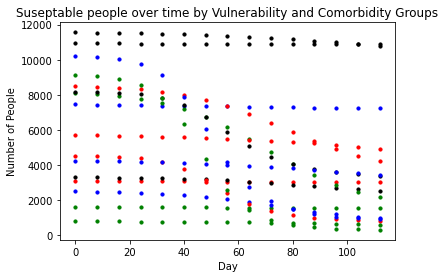

In [79]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    for b in range(0,4):
        ax.scatter(a,sim[1][a][b][0],c='black',s=10)
        ax.scatter(a,sim[1][a][b][1],c='red',s=10)
        ax.scatter(a,sim[1][a][b][2],c='blue',s=10)
        ax.scatter(a,sim[1][a][b][3],c='green',s=10)
plt.title('Suseptable people over time by Vulnerability and Comorbidity Groups')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

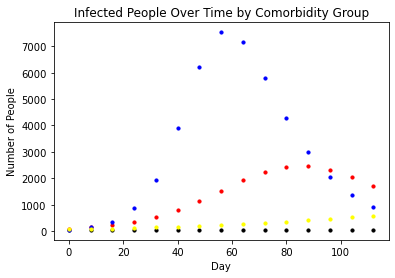

In [80]:
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    ax.scatter(a,sim[2][a][0],c='black',s=10)
    ax.scatter(a,sim[2][a][1],c='red',s=10)
    ax.scatter(a,sim[2][a][2],c='blue',s=10)
    ax.scatter(a,sim[2][a][3],c='yellow',s=10) 
plt.title('Infected People Over Time by Comorbidity Group')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

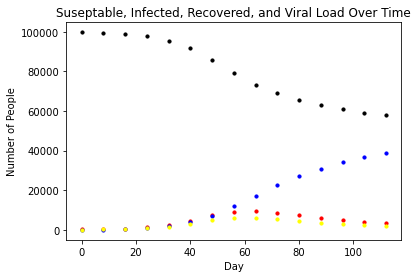

In [81]:
fig,ax=plt.subplots(sharex=True)
SIR=np.array(sim[0])
for a in range(0,120,8):
    ax.scatter(a,SIR[a][0],c='black',s=10)
    ax.scatter(a,SIR[a][1],c='red',s=10)
    ax.scatter(a,SIR[a][2],c='blue',s=10)
    ax.scatter(a,sim[3][a],c='yellow',s=10)
plt.title('Suseptable, Infected, Recovered, and Viral Load Over Time')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

**3. Do the shapes of S, I, R look similar to what you expected? Which of these plots is the “curve” people refer to when they say “flatten the curve”?**

The shapes of the model look about right except that we were not expecting the huge difference in scale between S and I or R after 120 days. The overall shape however is what we expected based off of what we learned in class and off of over COVID models currently available. Moreover, it is clear that the comorbidity groups largely impact the infected population over time, which makes perfect sense. When people say 'flatten the curve,' they are refering to the infected population curve (in blue on the last plot).

**4. Do you observe that some Sv,c compartments converged to zero while others converged to a positive value? Why do you think that is?**

Yes, we did observe some compartments converging to positive values other then zero. We believe that is because specific βv,c values have a large affect on the overall model, especially because it is the reciprocal of the typical time until an infected person recovers, making it play a large part on the time series.

In [82]:
## Print the percentages of population that never got infected for all compartments (i.e. all values
## of v and c)

OriginalSvcPopulations = pd.DataFrame(Svc_0) * (N - I_0)
SvcFinalDay = sim[1][119]
PercentNotInfectedvc = SvcFinalDay / OriginalSvcPopulations
PercentNotInfectedvc

,0,1,2,3
0,0.997734,0.754609,0.409435,0.921790
1,0.977971,0.470857,0.174924,0.848047
2,0.967487,0.360157,0.084476,0.777671
3,0.957327,0.242724,0.030676,0.724218


In [83]:
## Redo but multiply all Beta values by 1/4. How does this change plots?

BvcRedo = Bvc * (1/4)

Svc = pd.DataFrame(Svc_0) * (N - I_0)
Ic = Ic_0
I = I_0
S = Svc.sum().sum()
R = 0
simRedo = simulation(t, Svc, Ic, N, BvcRedo, gamma, Lc,I_0)

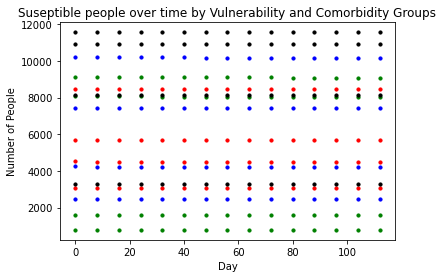

In [84]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    for b in range(0,4):
        ax.scatter(a,simRedo[1][a][b][0],c='black',s=10)
        ax.scatter(a,simRedo[1][a][b][1],c='red',s=10)
        ax.scatter(a,simRedo[1][a][b][2],c='blue',s=10)
        ax.scatter(a,simRedo[1][a][b][3],c='green',s=10)
plt.title('Suseptible people over time by Vulnerability and Comorbidity Groups')
plt.ylabel('Number of People')
plt.xlabel('Day')

plt.show()

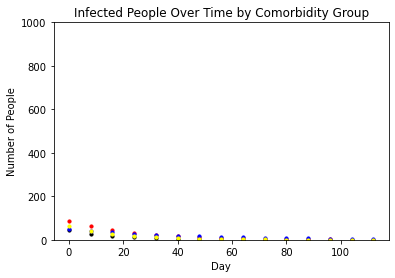

In [85]:
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    ax.scatter(a,simRedo[2][a][0],c='black',s=10)
    ax.scatter(a,simRedo[2][a][1],c='red',s=10)
    ax.scatter(a,simRedo[2][a][2],c='blue',s=10)
    ax.scatter(a,simRedo[2][a][3],c='yellow',s=10) 
plt.ylim(0, 1000)

plt.title('Infected People Over Time by Comorbidity Group')
plt.ylabel('Number of People')
plt.xlabel('Day')

plt.show()

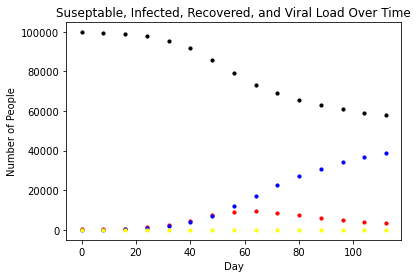

In [86]:
fig,ax=plt.subplots(sharex=True)
SIRRedo=simRedo[0]
for a in range(0,120,8):
    ax.scatter(a,SIR[a][0],c='black',s=10)
    ax.scatter(a,SIR[a][1],c='red',s=10)
    ax.scatter(a,SIR[a][2],c='blue',s=10)
    ax.scatter(a,simRedo[3][a],c='yellow',s=10)
    
plt.title('Suseptable, Infected, Recovered, and Viral Load Over Time')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

What happened to the S, I, R plots? Did the “curve” flatten compared to the previous case?

The plots changed drastically dy reducing the beta rate. Since the disease was being spread at a much slower rate, all v,c groups declined in cases over time, and the curve most definetly 'flattened.'

In [87]:
## Print the percentages of population that never got infected withthese βv,c values.

OriginalSvcPopulations = pd.DataFrame(Svc_0) * (N - I_0)
SvcFinalDay = simRedo[1][119]
PercentNotInfectedvcRedo = SvcFinalDay / OriginalSvcPopulations

In [88]:
PercentNotInfectedvc ## Many less people in each group were infected at a lower beta value

,0,1,2,3
0,0.997734,0.754609,0.409435,0.921790
1,0.977971,0.470857,0.174924,0.848047
2,0.967487,0.360157,0.084476,0.777671
3,0.957327,0.242724,0.030676,0.724218


In [89]:
part2 = np.load("part1b.npz")
part2.files
Ic_0 = part2["Ic_0"]
N = part2["N"]
gamma = part2["gamma"]
Lc = part2["Lc"]
L_validation = part2["L_validation"]
L_test = part2["L_test"]
betas_validation = part2["betas_validation"]
pmfs = [[0.5, 0.3, 0.1, 0.1],[0.4, 0.3, 0.2, 0.1],[0.3,0.3,0.2,0.2],[0.1, 0.2, 0.3, 0.4]]
SVC0 = []
for item in pmfs:
    for i in range(5):
        SVC0.append(item)
SVC0 = np.array(SVC0)
Svc = pd.DataFrame(SVC0) * (N - I_0)
Lc = [Lc]*20
I_0 = Ic_0.sum()

          0        1        2        3
0   24873.5  14924.1   4974.7   4974.7
1   24873.5  14924.1   4974.7   4974.7
2   24873.5  14924.1   4974.7   4974.7
3   24873.5  14924.1   4974.7   4974.7
4   24873.5  14924.1   4974.7   4974.7
5   19898.8  14924.1   9949.4   4974.7
6   19898.8  14924.1   9949.4   4974.7
7   19898.8  14924.1   9949.4   4974.7
8   19898.8  14924.1   9949.4   4974.7
9   19898.8  14924.1   9949.4   4974.7
10  14924.1  14924.1   9949.4   9949.4
11  14924.1  14924.1   9949.4   9949.4
12  14924.1  14924.1   9949.4   9949.4
13  14924.1  14924.1   9949.4   9949.4
14  14924.1  14924.1   9949.4   9949.4
15   4974.7   9949.4  14924.1  19898.8
16   4974.7   9949.4  14924.1  19898.8
17   4974.7   9949.4  14924.1  19898.8
18   4974.7   9949.4  14924.1  19898.8
19   4974.7   9949.4  14924.1  19898.8


In [90]:
#grid search
from sklearn.metrics import mean_squared_error
beta_grid= np.linspace(0,1,20)
#something is to large in our simulation
mmse=np.inf
beta_mmse=np.nan
t=20
i=0
betaMMSE = []
for beta in beta_grid:
    local_mmse = np.inf
    Ic_vc = Ic_0[i]    
    Lc_vc = Lc[i]
    simTrial=simulation(t, Svc, Ic_vc, N, beta, gamma, Lc_vc, I_0)
    mse = mean_squared_error(L_validation[i], simTrial[3])
    print(mse)
    local_mmse = mse if mse < local_mmse else local_mmse
    (mmse, optimal_beta) = (local_mmse, beta) if (local_mmse < mmse) else (mmse,optimal_beta)
    i=i+1

53454.401611459114
2058932.5167782377
1173614453.2055416
19097399303.56286
40772250501.52341
56444256425.990906
73297173191.66269
79163296833.50862
90968671160.51129
91763653192.55716
90325564526.3909
113296814504.42644
116566083402.40378
113638824722.91196
145874966634.2507
154175760490.14172
158528845807.1231
188096826292.69464
173248174796.60587
183648721735.57507
